In [22]:
from fbm import fbm, fgn, times
import numpy as np 
from scipy.stats import norm 
import matplotlib.pyplot as plt
import time as time

## Fractional Brownian Motion 

* Module for modeling fractional brownian motion 
* Vary over the hurst to see the results of the different sample paths 
* Persistant and anti-persistant behaviors

In [23]:
# Generate a fBm realization
fbm_sample = fbm(n=1024, hurst=0.75, length=1, method='daviesharte')
brownian_sample = fbm(n=1024, hurst=0.5, length = 1, method='daviesharte')

# Generate a fGn realization
fgn_sample = fgn(n=1024, hurst=0.75, length=1, method='daviesharte') #Sampling a Gaussian at each time index

# Get the times associated with the fBm
t_values = times(n=1024, length=1)

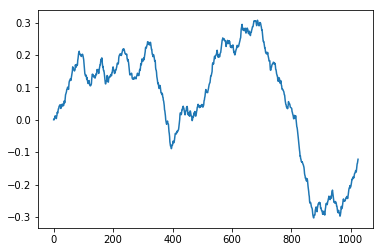

In [24]:
plt.plot(fbm_sample)
plt.show()

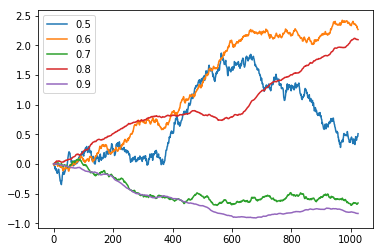

In [25]:
hursts = np.linspace(0.5, 0.9, 5) #range of hurst parameters 
fig, ax = plt.subplots() 

for i in range(5): 
    fbm_sample = fbm(n = 1024, hurst = hursts[i], length = 1, method = 'daviesharte')
    ax.plot(fbm_sample, label = hursts[i])
    ax.legend()
    

## Things I need to figure out 

### How to train? 
- Train the neural network using the implied volatilities generated
- Need to put it in the correct format.


### What we have left to do? 
- This is with respect to Blanka or Bayer. And the optimization after the training to solve for something. Forgeter what (look up). 
- Levenberg Marquadt.
- BFGS etc etc other methods

- The numpy array needs to be complete. I think the only one to try is for Bayer. Can't blanka it would take forever (see next point for Blanka). 
- Might be able to use Blanka's method if we are able to generate data with GAN
- Also need to implement GAN for checking if it gets us better results.

### How to test? 
- Use the trained neural network to figure out the pricing functional 
- Performance evaluation compare the performance evaluation with other models 
    - long memory model bayer
    - long memory model blanka 
  
- Time it takes for monte carlo vs GAN performance. 

In [10]:
L = 255 #no. of discrete sampels of the brownian motion
N = 50 #no. of sample paths to average the paths over
NN = int(14) #no. data points per parameter (14**4 = 38,416)

##Grid for strikes and maturities this is taken directly from blanka 
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

#Model parameter ranges 
alb, aub = -0.003, -0.001 
blb, bub = 0.1, 0.5
rlb, rub = 0.01, 0.04
hlb, hub = 0.51, 89 

A = np.arange(alb, aub, (aub - alb)/NN)
V = np.arange(blb, bub, (bub - blb)/NN)
R = np.arange(rlb, rub, (rub - rlb)/NN)/L #only divide by L here.
H = np.arange(hlb, hub, (hub - hlb)/NN)

In [15]:
Y = np.zeros(L) #Volatility process 
S = np.zeros((L, N)) #Initialize the stock price array
S[0] = 100. #initial stock price: normalize? 
K = 105. #strike price: normalize? 
T = 1 #Annual Maturity
T_data = np.zeros((NN**4 , 6)) #Initial data array

In [16]:
start_time = time.time()
for nnh in range(NN): 
    #hurst parameter for the process coefficient
    h = H[nnh]
    disp=str(nnh+1)+"/"+str(NN)+"  "+ "Hurst" +" "+ str(h)
    print (disp, end="\r")
    
    for nnr in range(NN): 
        #risk-Free interest rate for interval since it is annual_rate/L
        r = R[nnr]
        
        for nnb in range(NN): 
            #volvol process coefficient 
            b = V[nnb]

            for nna in range(NN): 
                #diffusion process coefficient 
                a = A[nna]

                for j in range(N): 
                    #loop for taking multiple sample paths
                    #sample the fBm with corresponding h
                    B = fbm(n=L, hurst=h, length=1, method='daviesharte') #changed the n to 500 

                    for i in range(1, L): 
                        #Euler's approximation to calculate the asset price sequence
                        Y[i] =  Y[i-1]*(1 + a) + b*(B[i] - B[i-1]) 
                        #The 2D array S has a single sample path in each column. The last row = stock price at maturity. 
                        S[i, j] =  S[i-1, j]*(1 + r) + np.exp(Y[i])*np.random.normal(0,1) 

                    #Store the option prices for the 50 sample paths P.shape is (50, ) 
                    P = S[-1]-K
                PT_call = np.maximum(P, 0)
                PT_put = np.maximum(-P, 0)

                #Check for if any pricing negative.  
                if not(all(PT_call >= 0) and all(PT_put >= 0)): 
                    raise ValueError('Option price is negative')

                #Pricing function discounting using the risk free interest rate     
                P_call = np.mean(PT_call)*np.exp(-r*L*T) #European call option  
                P_put = np.mean(PT_put)*np.exp(-r*L*T) #European put option

                #Data array for the training samples (have to include this across all strikes and maturities)
                T_data[nna + nnb*NN + nnr*NN**2 + nnh*NN**3]= np.array([a, b, r*L, h, P_call, P_put]) #have to fix this the indexing 
end_time = time.time()

KeyboardInterrupt: 

In [ ]:
print("Total time taken to generate " +str(NN**4)+ " samples:", (end_time - start_time)/3600, 'hrs')

In [17]:
float_formatter = '{:.4f}'.format
np.set_printoptions(formatter={'float_kind':float_formatter})

print('Strike Price='+str(K))
print('Stock Price='+str(S[0, 0]))
print('Annual Maturity') #Introduce a control for this so that I can genrate maturity between n years

print('[[ a      b      r      H      Call    Put]')
print(T_data[:20])

Strike Price=105.0
Stock Price=100.0
Annual Maturity
[[ a      b      r      H      Call    Put]
[[-0.0030 0.1000 0.0100 0.5100 4.5241 11.0779]
 [-0.0029 0.1000 0.0100 0.5100 3.0079 7.7438]
 [-0.0027 0.1000 0.0100 0.5100 4.0897 8.5104]
 [-0.0026 0.1000 0.0100 0.5100 5.0815 7.3128]
 [-0.0024 0.1000 0.0100 0.5100 4.1224 8.1694]
 [-0.0023 0.1000 0.0100 0.5100 5.9114 6.1491]
 [-0.0021 0.1000 0.0100 0.5100 5.4173 7.9461]
 [-0.0020 0.1000 0.0100 0.5100 5.4066 7.4552]
 [-0.0019 0.1000 0.0100 0.5100 4.6249 10.0779]
 [-0.0017 0.1000 0.0100 0.5100 3.3525 7.5888]
 [-0.0016 0.1000 0.0100 0.5100 4.9367 5.9532]
 [-0.0014 0.1000 0.0100 0.5100 5.7758 8.4018]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.00

In [ ]:
a = -0.002#has to be negative (mean-reverting property)
b = 0.25 #variable 
r = 0.02 #annual risk free interest rate 
L = 500 #time intervals in a year
B = fbm(n=L, hurst=0.85, length=1, method='daviesharte')   
S = np.zeros(L)
S[0] = 100 #stock price 
Y = np.zeros(L)
for i in np.arange(1, L): 
    Y[i] =  Y[i-1]*(1 + a) + b*(B[i] - B[i-1]) 
    S[i] =  S[i-1]*(1 + r/L) + np.exp(Y[i])*np.random.normal(0,1)

In [ ]:
plt.plot(S)
plt.show()

### Generate the pathological cases for the model  

* Play around the units. I had to divide the r by L. 
    * If r is the annual rate, then r/L is the interval adjusted rate 
    * When we discount we also have to divide the the time index by L. Otherwise it diverges. (Why?)

* What creates these pathological cases? What is the reasoning behind them?
* Does discounting help? No, there is linear behavior at the end. 
* How does this linear behavior come around? Can we explain it? 

### Using pandas to handle big data frames 

* Go thru a tutorial for the pandas data frame.  
* How to save a numpy array to use in another file? 
* Read up on persistant and anti-persistant proceseses.

### Post-processing Step 

* Calculating the implied volatility

In [ ]:
def black_scholes(S0, K, r, T, s): 
    """Calculates the black scholes pricing for european call options. 
    As well as the first derivative w.r.t implied volatility.  
    
    Inputs: S0 = stock price 
            K  = strike price 
            r  = risk-free interest rate 
            T  = time to maturity in years  
            s  = volatility (standard deviation of log returns) 
    Outputs: 
            C0 = price of the call option
    """
    
    X = np.log(S0/K)
    D = s*np.sqrt(T)
    K0 = K*np.exp(-r*T)
    
    d1 = (X + (r + s**2/2)*T)/D
    dd1 = -(X+r*T)/(s*D) + np.sqrt(T)
#     d2 = (X + (r - s**2/2)*T)/D
    d2 = d1 - D
#     dd2 = -(X+r*T)/(s*D)
    dd2 = dd1 - np.sqrt(T)

    C0 = S0*norm.cdf(d1) - K0*norm.cdf(d2)
    dC0 = S0*norm.pdf(d1)*dd1 + K0*norm.pdf(d2)*dd2
    return C0, dC0 
    
    
def calculate_IV(C0, S0, K, r, T):
    """ Calculates the implied volatility for given inputs using Newton's Method
    Inputs: C0 = BScholes calculated option price 
            S0 = stock price
            K  = strike price
            r  = risk-free interest rate 
            T  = time to maturity in years
    Output: 
            s = implied volatility"""
    tolerance = 1e-5 #0.1 percent accuracy 
    s = np.random.uniform(0.01, 0.5) # initializing volatility between 1% and 50% 
    while True: 
        f, df = black_scholes(S0, K, r, T, s)
        if df == 0: 
            print('derivative is 0')
            return s 
        s1 = s - (C0-f)/df 
        t = np.abs(s1 - s)
        if t < tolerance: 
            break 
        s = s1 
    return s      